<font size=8> Network Tests


In [1]:
#Common Python Packages
from pickle import TRUE
import pickle
import numpy as np
import matplotlib.pyplot as plt
import timeout_decorator

#dynapse2 spikegen imports
from lib.dynapse2_util import *
from lib.dynapse2_network import Network
from lib.dynapse2_spikegen import send_events,get_fpga_time, send_virtual_events, poisson_gen, isi_gen,regular_gen
from lib.dynapse2_raster import *
from lib.dynapse2_obj import *

#Statistics imports
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.signal import butter, filtfilt
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from itertools import product
#my imports
from adaptation import pc_single,ff,pc_pv_sst,ff_network
from adaptation_lib.spike_stats import *
from adaptation_lib.dynapse_setup import *
from adaptation_lib.graphing import *
from configs import neuron_configs_bio



@timeout_decorator.timeout(40)  # Set a 5-second timeout
def run_simulation(neuron_config):
    return pc_pv_sst.pc_pv_sst(
        board=board,
        profile_path=profile_path,
        number_of_chips=number_of_chips,
        neuron_config=neuron_config
    )

<font size=7> Manual Tuning


In [2]:
[board,profile_path,number_of_chips]=obtain_board()

In [1]:
neuron_config=neuron_configs_bio.config()

neuron_config['PC_W0']=[4,100]# PC input
neuron_config['PC_W1']=[1,100]#recurrent PC to PC
neuron_config['PC_W2']=[2,100]#PV shunt inhibition to PC
neuron_config['PC_W3']=[2,100]#SST gaba inhibition to PC

neuron_config['PV_W1']=[1,100]#PC_to PV
neuron_config['PV_W2']=[4,250]#PV gaba inhibition to PV
neuron_config['PV_W3']=[2,100]#SST gaba inhibition to PV

neuron_config['SST_W0']=[4,100]#input weight to PC
neuron_config['SST_W1']=[4,200]#PC to SST weight
neuron_config['SST_W2']=[0,50]#PV shunt inhibition to SST

neuron_config['nvn']=15
neuron_config['pcn']=100
neuron_config['pvn']=20
neuron_config['sstn']=15

neuron_config['SST_AMPA_GAIN']=[2,155]
neuron_config['SST_AMPA_TAU']=[1,10]
neuron_config['SST_LEAK']=[1,30]

neuron_config['Input_PC']=.3
neuron_config['Input_PV']=.11#.2
neuron_config['Input_SST']=.1#.1#.1

neuron_config['PC_PC']=.2
neuron_config['PC_PV']=.15#.1
neuron_config['PC_SST']=.3#.1

neuron_config['PV_PV']=.2#.2
neuron_config['PV_PC']=.2#0
neuron_config['PV_SST']=.2#.2

neuron_config['SST_PC']=.3#.1
neuron_config['SST_PV']=.2#.2

neuron_config['PC_Adaptation']=True
neuron_config['duration']=15
neuron_config['input_type']='Regular'
neuron_config['in_freq']=20

[output_events,test_config]=pc_pv_sst.pc_pv_sst(board=board, profile_path=profile_path, number_of_chips=number_of_chips,neuron_config=neuron_config)
[cv_values,synchrony_values]=run_dynamic_anal(output_events,test_config)
if 'raster_fig' in locals() and raster_fig is not None:
    raster_fig.savefig('raster_previous.png')
if 'fvt_fig' in locals() and fvt_fig is not None:
    fvt_fig.savefig('fvt_previous.png')
raster_fig=script_annotated_raster_plot(test_config,output_events,neuron_config,cv_values=cv_values,syn_values=synchrony_values,save=True,annotate=False,annotate_network=True)
fvt_fig=frequency_vs_time_plot(frequency_over_time(test_config,output_events),test_config,save=True,annotate=False,show=True)
raster_fig.savefig('raster_current.png')
fvt_fig.savefig('fvt_current.png')



NameError: name 'neuron_configs_bio' is not defined

In [7]:

def calculate_slope(time_axis, ff_windows_sst):
    slope, intercept, r_value, p_value, std_err = linregress(time_axis, ff_windows_sst)
    return slope


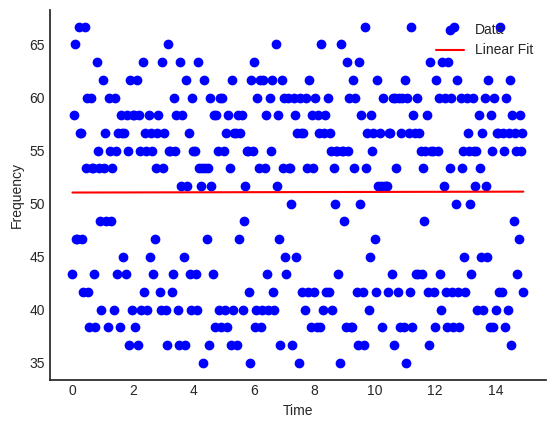

In [21]:
# Setting Seaborn style

# Your function call for frequency over time
[time_axis,ff_windows_pc,ff_windows_pv,ff_windows_sst] = frequency_over_time(test_config,output_events)

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(time_axis, ff_windows_sst)

# Scatter plot of the data
plt.scatter(time_axis, ff_windows_sst, label='Data', color='blue')

# Line plot of the linear regression
plt.plot(time_axis, intercept + slope * np.array(time_axis), label='Linear Fit', color='red')

# Labels
plt.xlabel('Time')
plt.ylabel('Frequency')

# Removing right and top axes
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Legend
plt.legend()

# Displaying the plot
plt.show()

In [32]:
import random
neuron_config=neuron_configs_bio.config()

def randomize_config(neuron_config):
    neuron_config['SST_W0'] = [random.randint(1, 3), random.randint(10, 250)]
    neuron_config['SST_AMPA_GAIN'] = [random.randint(1, 3), random.randint(10, 250)]
    neuron_config['SST_AMPA_TAU'] = [random.randint(0, 1), random.randint(10, 250)]
    neuron_config['SST_LEAK']= [0, random.randint(20, 250)]

    neuron_config['Input_SST'] = random.uniform(.05, .5)

    neuron_config['PC_SST'] = random.uniform(.05, .5)

    neuron_config['PC_Adaptation'] = True
    neuron_config['duration'] = 15
    neuron_config['input_type'] = 'Regular'
    neuron_config['in_freq'] = 20

    return neuron_config


@timeout_decorator.timeout(40)  # Set a 5-second timeout
def run_simulation(neuron_config):
    return pc_pv_sst.pc_pv_sst(
        board=board,
        profile_path=profile_path,
        number_of_chips=number_of_chips,
        neuron_config=neuron_config
    )

successful_simulations = 0

for i in range(1000):  # Example: Keep trying different configurations until 100 successful simulations
    neuron_config = randomize_config(neuron_config)  # Assuming you've updated randomize_config without an argument
    try:
        [output_events, test_config] = run_simulation(neuron_config)
        [cv_values, synchrony_values] = run_dynamic_anal(output_events, test_config)
        raster_fig = script_annotated_raster_plot(test_config, output_events, neuron_config, cv_values=cv_values, syn_values=synchrony_values, save=True, annotate=False, annotate_network=True)
        fvt_fig = frequency_vs_time_plot(frequency_over_time(test_config, output_events), test_config, save=True, annotate=False, show=True)
        raster_fig.savefig(f'raster_current.png')
        fvt_fig.savefig(f'fvt_curernt.png')
        print(f"Simulation {successful_simulations + 1} completed successfully!")
        successful_simulations += 1
        
        if successful_simulations >= 2000: # Stop after 100 successful simulations
            break
    except timeout_decorator.TimeoutError:
        print("Simulation timed out, trying again with new parameters...")

print("Completed 100 successful simulations.")


Setting Latches
Setting up network
Adding connections

Setting monitors
10 80 10

PC Neurons

[221, 235, 201, 211, 223, 230, 252, 253, 237, 234, 236, 250, 169, 180, 183, 189, 204, 227, 242, 188, 194, 207, 248, 251, 203, 215, 219, 228, 196, 165, 171, 181, 195, 220, 222, 244, 149, 156, 164, 179, 205, 206, 217, 226, 238, 254, 148, 157, 158, 210, 214, 232, 245, 246, 131, 152, 161, 163, 167, 173, 176, 198, 200, 209, 231, 233, 113, 146, 170, 190, 192, 197, 229, 247, 249, 115, 118, 139, 141, 143]

PV Neurons

[255, 252, 202, 233, 239, 223, 206, 238, 251, 173]

PV Neurons

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

All configurations done!

Input events created
initilize run dynapse
initilize run dynapse

getting fpga time


setting virtual neurons



TypeError: <class 'int'> could not be casted to expected type (unsigned int), integer bounds [0,4294967295]

In [26]:
from itertools import product

neuron_config = neuron_configs_bio.config()

neuron_config['PC_Adaptation'] = True
neuron_config['duration'] = 15
neuron_config['input_type'] = 'Regular'
neuron_config['in_freq'] = 20
neuron_config['nvn'] = 15
neuron_config['pcn'] = 100
neuron_config['pvn'] = 20
neuron_config['sstn'] = 15

param_grid = {
    'sst_w0': product([2,5],[10,100,150,250]),
    'sst_ampa_gain': product([1, 3], [10,100,150, 250]),
    'sst_ampa_tau': product([0, 1], [10,100,150, 250]),
    'sst_leak': product([0], [20, 250]),
    'input_sst': [.05, .1,.2,.3],
    'pc_sst': [.05, .1,.2,.3]
}

# Flatten the product for the first four parameters
expanded_param_grid = {
    key: list(value) for key, value in param_grid.items()
}

param_values = list(expanded_param_grid.values())
total_combinations = len(list(product(*param_values))) # Total number of parameter combinations

# Load previous results if available
try:
    with open('results.pkl', 'rb') as f:
        results = pickle.load(f)
except FileNotFoundError:
    results = []

# Iterate through the parameter grid
for i, params in enumerate(product(*param_values), start=len(results)):
    print(f"Running simulation {i+1}/{total_combinations}...")

    # Create a dictionary of the current parameter values, flattening product objects
    current_params = {
        key: (item[0], item[1]) if isinstance(item, product) else item
        for key, item in zip(expanded_param_grid.keys(), params)
    }

    # Update the values in neuron_config with the current parameter values
    neuron_config.update(current_params)

    try:
        [output_events, test_config] = run_simulation(neuron_config)
        [time_axis, ff_windows_pc, ff_windows_pv, ff_windows_sst] = frequency_over_time(test_config, output_events)
        slope = calculate_slope(time_axis, ff_windows_sst)
        results.append((current_params, slope))  # Storing the current_params instead of neuron_config
        
        # Save progress
        with open('results.pkl', 'wb') as f:
            pickle.dump(results, f)
    except timeout_decorator.TimeoutError:
        print("Simulation timed out, trying again with new parameters...")

print("Simulation completed")



Running simulation 1/16384...
{'input_type': 'Regular', 'PC_Adaptation': True, 'STD': False, 'DC_Latches': False, 'overtake_test': False, 'decay': False, 'duration': 15, 'in_freq': 20, 'in_DC': 0, 'plot_iter': False, 'n_iter': 20, 'Striated': False, 'duration1': 300000, 'duration2': 300000, 'rest_time': 200000, 'core_to_measure': 0, 'synapse_to_measure': 'ampa', 'neuron_to_measure': 10, 'test_type': 'neuron', 'DC_pulse': [3, 250], 'sweep': False, 'sweep_variable': 'SYAM_STDW_N', 'sweep_coarse_val': 0, 'sweep_range_fine': array([  0,  62, 125, 187, 250]), 'DC_Coarse': 2, 'DC_FI_Range': array([  0,  27,  55,  83, 111, 138, 166, 194, 222, 250]), 'Freq_FI_Range:': array([  0,  27,  55,  83, 111, 138, 166, 194, 222, 250]), 'nvn': 15, 'pcn': 100, 'pvn': 20, 'sstn': 15, 'Input_PC': 0.3, 'Input_PV': 0.11, 'Input_SST': 0.1, 'PC_PC': 0.2, 'PC_PV': 0.15, 'PC_SST': 0.3, 'PV_PC': 0.2, 'PV_PV': 0.2, 'PV_SST': 0.3, 'SST_PC': 0.3, 'SST_PV': 0.2, 'PC_LEAK': [1, 46], 'PC_GAIN': [0, 30], 'PC_REF': [1, 70

KeyboardInterrupt: 

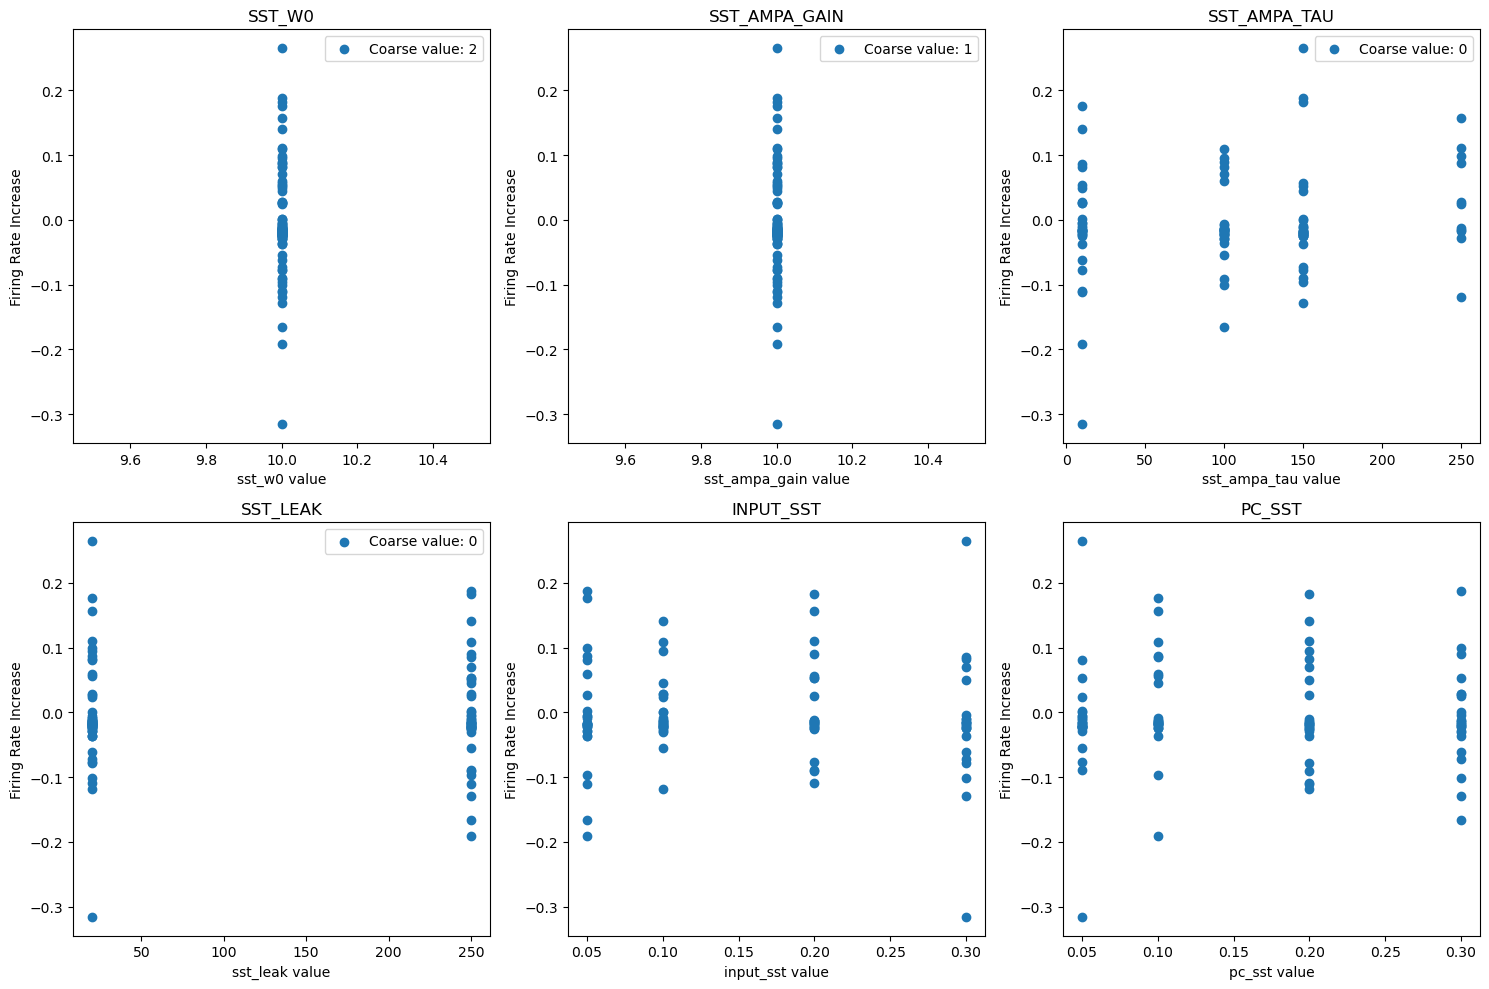

In [27]:
import matplotlib.pyplot as plt

# Parameters for which you want to create subplots
parameters = ['sst_w0', 'sst_ampa_gain', 'sst_ampa_tau', 'sst_leak', 'input_sst', 'pc_sst']

# Define the number of subplots (2 rows and 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the axes for easy iteration
axes = axes.flatten()

# Define marker shapes
markers = ['o', 's', 'v', '^', '<', '>']

# Iterate through each parameter and create subplots
for i, param in enumerate(parameters):
    # If the parameter is not from the first four, there's no coarse value
    if param in ['sst_w0', 'sst_ampa_gain', 'sst_ampa_tau', 'sst_leak']:
        unique_coarse_values = set([r[0][param][0] for r in results if param in r[0]])

        for j, coarse_value in enumerate(unique_coarse_values):
            # Filter the results for the current coarse value
            filtered_results = [(r[0][param][1], r[1]) for r in results if param in r[0] and r[0][param][0] == coarse_value]

            # Separate the fine values and the slopes
            fine_values, slopes = zip(*filtered_results)

            # Plot the data using different marker shapes for each coarse value
            axes[i].scatter(fine_values, slopes, label=f'Coarse value: {coarse_value}', marker=markers[j % len(markers)])
    else:
        # If the parameter is 'input_sst' or 'pc_sst', plot them directly
        values, slopes = zip(*[(r[0][param], r[1]) for r in results if param in r[0]])

        # Plot the data
        axes[i].scatter(values, slopes)

    axes[i].set_title(f'{param.upper()}')
    axes[i].set_xlabel(f'{param} value')
    axes[i].set_ylabel('Firing Rate Increase')

    # Add a legend to distinguish between different coarse values
    if param in ['sst_w0', 'sst_ampa_gain', 'sst_ampa_tau', 'sst_leak']:
        axes[i].legend()

plt.tight_layout()
plt.show()
